# Assignment 1 – Pulses
## Scientific Programming in Python with Applications in Physics
### Erwan Larié

In [102]:
# Import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import math

### Task 1

In ths part, we simply load the csv into a numpy array, check that we indeed get a 2D array, then remove the first column of the array containing the timestamps.

In [103]:
# Import the data using commas as delimiter since the values are separated this way.
# All the data is in ineger form, however since we might be doing value manipulation,
# it is better to keep the data type as float
raw_data = np.loadtxt("pulses.csv", delimiter=',')

# Check that the data was loaded into a 2D array
print("Array dimension:", raw_data.ndim)

# Let us isolate the data from the timestamp
ADC_readings = raw_data[:,1:]

Array dimension: 2


### Task 2

Defining a function here to apply the ADC readings to volt is not especially necessary, however it helps better understand what is associated with that formula.

In [104]:
def convert_to_voltage(adc_values):
    # V = 0.6 * x / (2^10 - 1)
    return 0.6*adc_values/(2**10-1)

volt_readings = convert_to_voltage(ADC_readings)

### Task 3
In order to plot the data, we first create the x axis which corresponds to an array representing the time evolution. From the instructions, each mesure is performed every 0.5 nanosecond: the x array should therefore represent this scale.

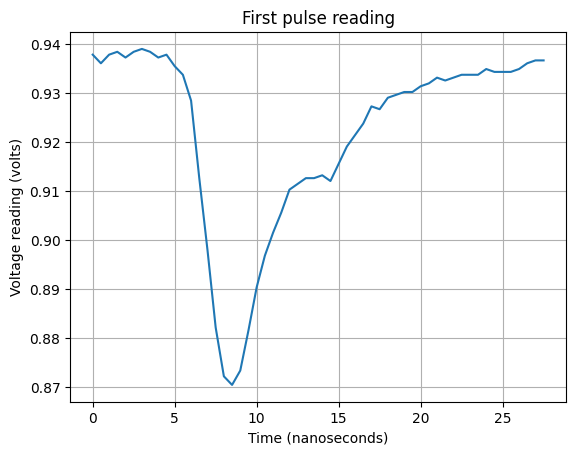

In [105]:
# Since we cannot directly specify the range without the upper limit, let's manipulate our range so it fits the unit step (0.5 ns)
time = np.arange(0, len(volt_readings[0]))*0.5

# Plot the data from the first row
fig, ax = plt.subplots()
ax.plot(time, volt_readings[0])
ax.set_xlabel('Time (nanoseconds)')
ax.set_ylabel('Voltage reading (volts)')
ax.set_title('First pulse reading');
ax.grid(True)

# Save the plot
plt.savefig("firstpulse.png")


### Task 4

From the graph above, we can estimate that the drop occurs around 5 nanoseconds, which corresponds to the 10th value (index 9 in the array).
From this index, we can determine the mean and substract it from the entire row.

Text(0.5, 1.0, 'Adjusted first pulse reading after correction')

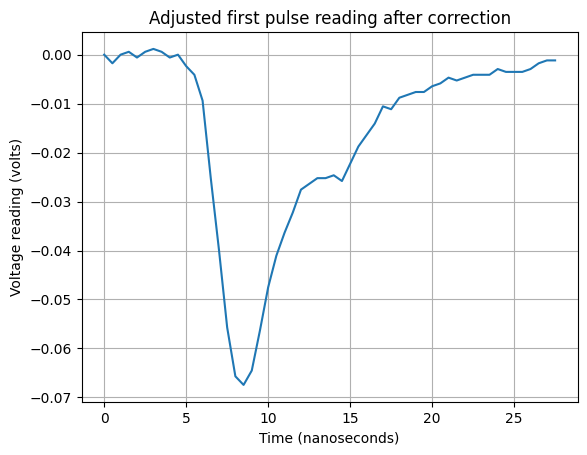

In [120]:
# The drop seems to be occuring around the 5 nanoseconds mark, i.e. after 10 measures
mean_sample_size = 10
mean_value = np.mean(volt_readings[0,:mean_sample_size-1])
adjusted_volt_readings = volt_readings[0] - mean_value

# Plot the adjusted data
fig, ax = plt.subplots()
ax.plot(time, adjusted_volt_readings)
ax.set_xlabel('Time (nanoseconds)')
ax.grid(True)
ax.set_ylabel('Voltage reading (volts)')
ax.set_title('Adjusted first pulse reading after correction')

### Task 5

  We will probably plot several graphs again so defining a function to display a number of graphs given that number and arrays seems more appropriate.

In the second part, the number of sample to determine the baseline mean is determined by estimating when the drop in values starts being pertinent. This can be numerically determined by looking when the gradient of those values starts noticeably rising. 

By looking into these gradient values and comparing them to graphs, an estimate threshold absolute value of 0.01 was deemed significant enough to be considered a drop in values.

By finding the index of the value corresponding to that drop in value, the mean can be dinamycally determined for each row and the baseline for each pulse computed.

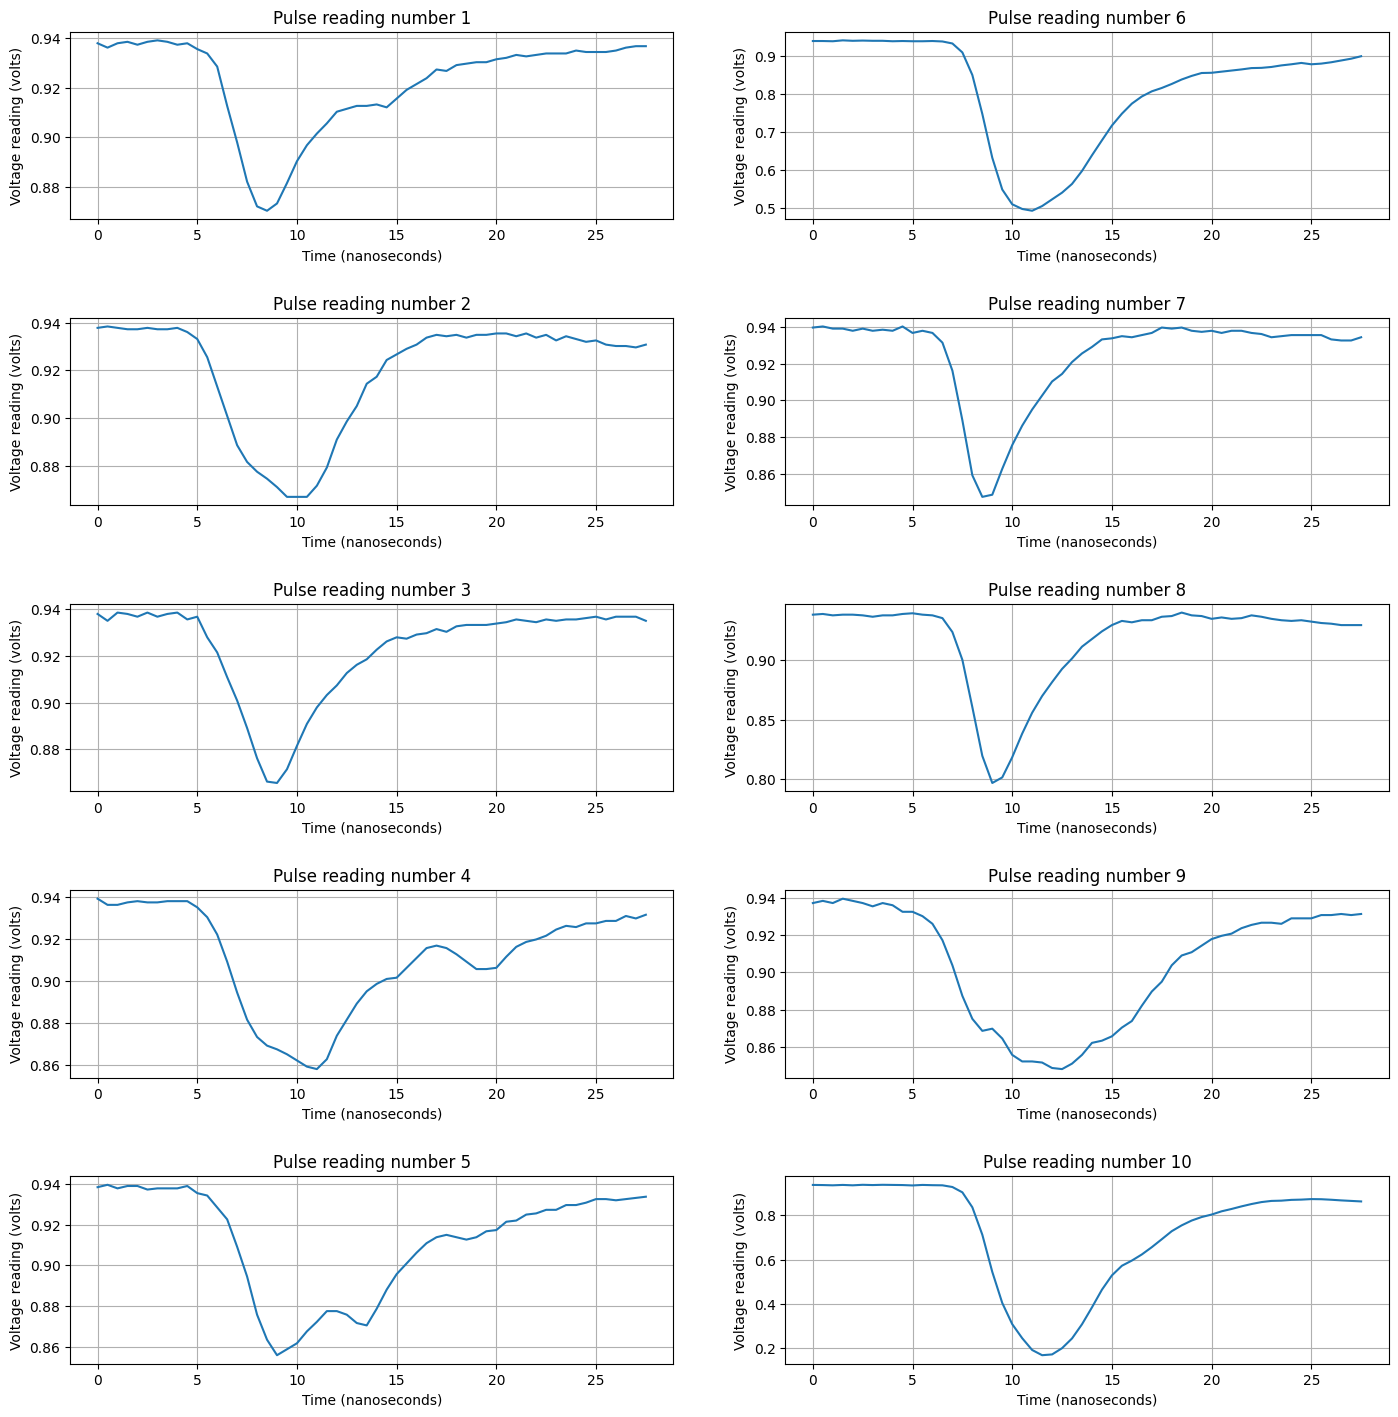

In [107]:
# Function used to plot a number of graphs in 2 columns - text is static for now as its use is restricted to the current case
# number_of_rows: number of rows from the y array value that we wish to display - should be higher than 0
# x_array_value: data to plot as the x axis
# y_array_value: 2D data array to plot as the y axis 
# corrected: boolean to indicate if we work with corrected values or not - default value is False
def plot_first_rows(number_of_rows, x_array_value, y_array_value, corrected = False):
    # Handle wrong number of rows
    if number_of_rows < 1 :
        print("Incorrect number of row value")
        return
    # Handle wrong length of array for x values - does not handle multi-dimensional x array
    if np.shape(y_array_value)[1] != len(x_array_value) : 
        print("Mismatching x and y arrays")
        return
    # Handles given number of rows higher than actual number of rows
    if np.shape(y_array_value)[0] < (number_of_rows-1):
        print("Restricting number of rows to max value of rows")
        number_of_rows = y_array_value
    # Prepare n/2 subplots
    # If n is odd, an extra subplot is prepared and will be deleted at the end
    fig, axs = plt.subplots(math.ceil(number_of_rows/2),2, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    # Prepare the labels and titles
    xlabel = 'Time (nanoseconds)'
    ylabel = 'Voltage reading (volts)'
    if corrected :
        plot_title = 'Corrected pulse reading number '
    else :
        plot_title = 'Pulse reading number '

    
    for i in range(math.floor(number_of_rows/2)):
        # First column
        axs[i][0].plot(x_array_value, y_array_value[i])
        axs[i][0].set_xlabel(xlabel)
        axs[i][0].set_ylabel(ylabel)
        axs[i][0].set_title(plot_title + str(i+1))
        axs[i][0].grid(True)

        #Second column
        axs[i][1].plot(x_array_value, y_array_value[i + math.floor(number_of_rows/2)])
        axs[i][1].set_xlabel(xlabel)
        axs[i][1].set_ylabel(ylabel)
        axs[i][1].set_title(plot_title + str(i+ math.floor(number_of_rows/2) +1))
        axs[i][1].grid(True)
        
    if number_of_rows%2 == 1 :
        # If the demanded number of rows is odd, plot the final expected row and delete the last subplot
        axs[-1][0].plot(x_array_value, y_array_value[number_of_rows - 1])
        axs[-1][0].set_xlabel(xlabel)
        axs[-1][0].set_ylabel(ylabel)
        axs[-1][0].set_title(plot_title + str(number_of_rows))
        axs[-1][0].grid(True)
        fig.delaxes(axs[-1][1])
        
    plt.show()

# Call the function to plot first 10 rows
plot_first_rows(10, time, volt_readings)

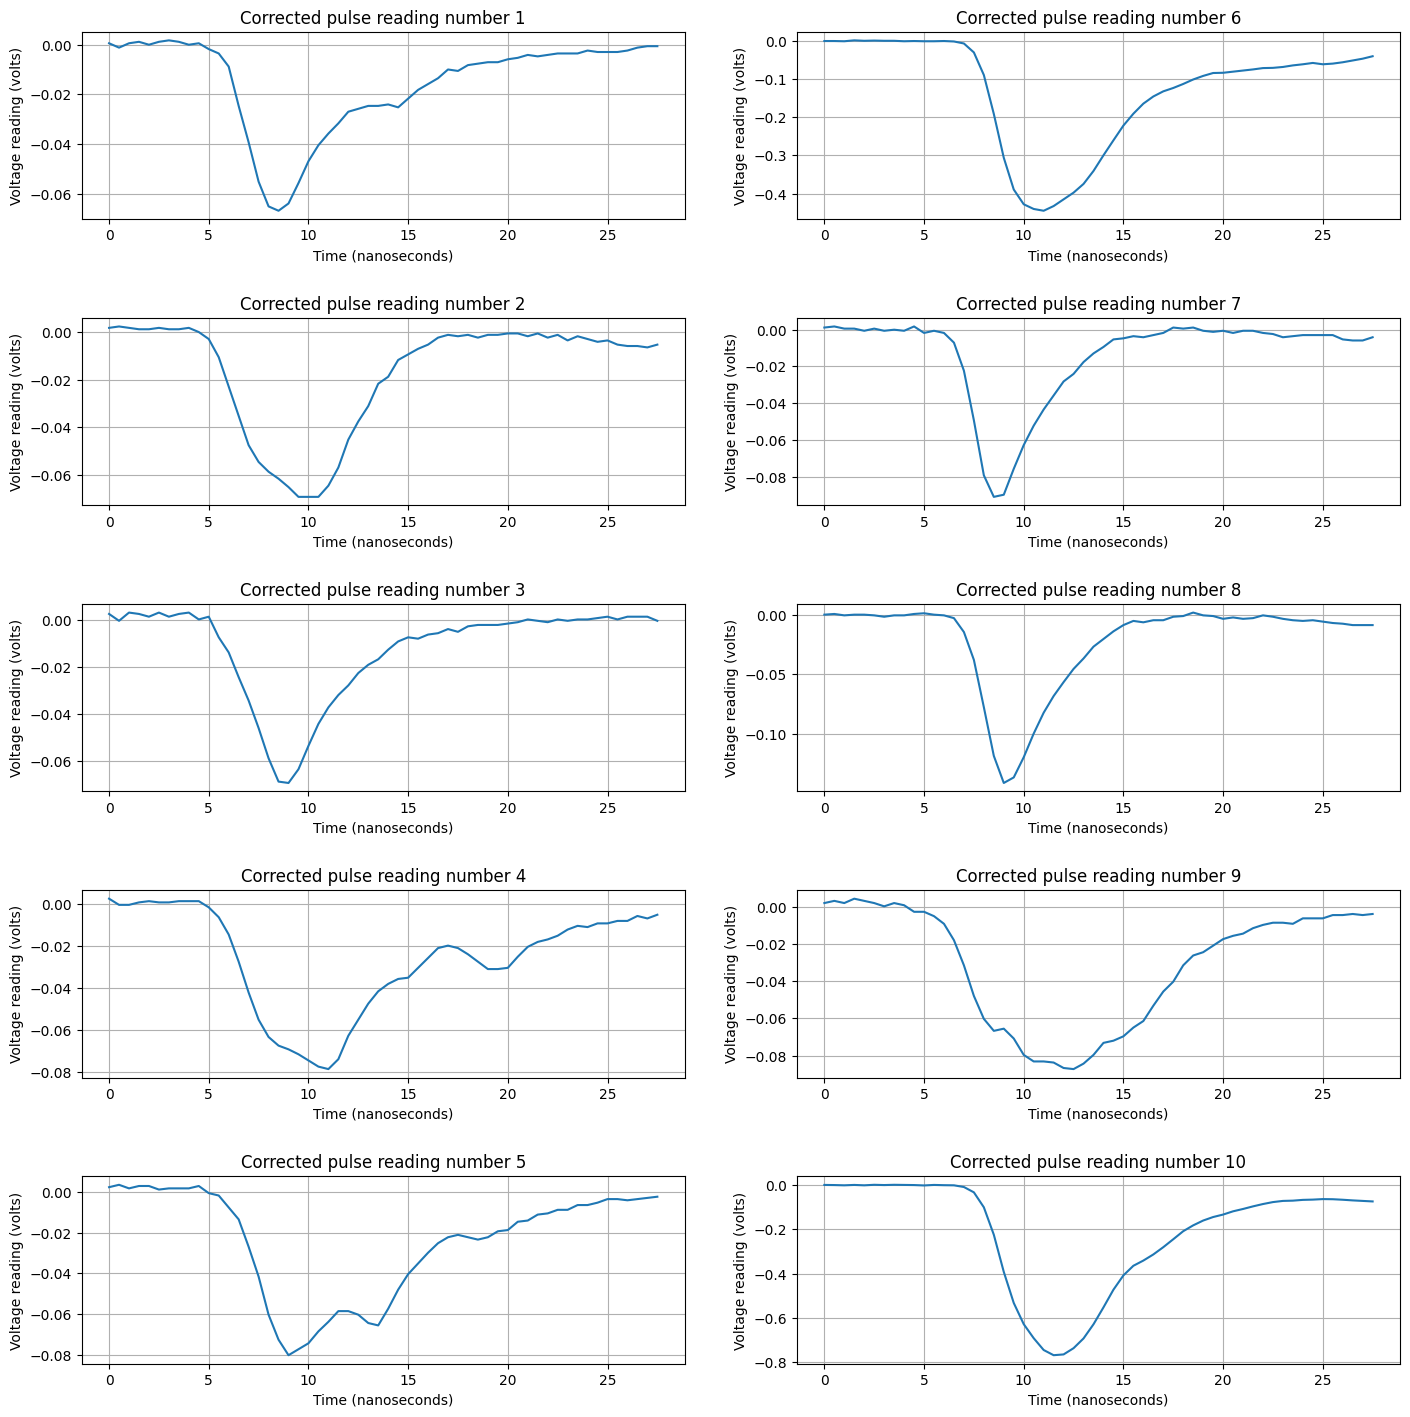

In [110]:
# Function used to compute the mean baseline and remove it from each row from the given array 
# No need to specify a number of rows, we perform the operation on the whole provided array
# value_array: array of values upon which the baseline will be corrected
# retuns an array consisting of the input array with its baseline deducted
def compute_corrected_sample(value_array):
    # Create an empty array with the same dimensions as the provided array
    output_array = np.empty_like(value_array)

    # Iterate over each row of the provided array
    for i in range(np.shape(value_array)[0]) :
        # Calculate the gradient values
        grad_values = np.gradient(value_array[i])
        
        # Find the index of the first significant gradient value (here arbitrarily from observed gradient values > 0.01)
        firstIndex = next((index for index, value in enumerate(grad_values) if abs(value) > 0.01), -1)
        
        # Use the found first index to calculate the mean of the row baseline
        mean_value = np.mean(value_array[i,:firstIndex])
        
        # Remove the baseline from the row values and store it in the empty array
        output_array[i] = value_array[i] - mean_value
    
    return output_array

# Correct the values of the first 10 rows of the voltage readings
corrected_readings = compute_corrected_sample(volt_readings[:10])
# Plot those corrected values
plot_first_rows(10, time, corrected_readings, True)

# Task 6

Text(0.5, 1.0, 'Pulse value sum repartition')

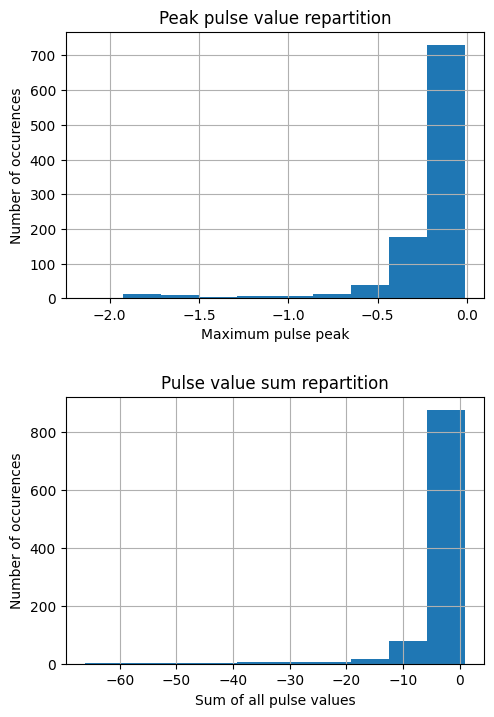

In [119]:
# Compute the corrected values of every row from the CSV
all_corrected_readings = compute_corrected_sample(volt_readings)

# Compute the minimum value of each row (i.e. the maximum reading value)
max_sensor_readings = all_corrected_readings.min(axis=1)

# Compute the sum value of each row
summed_sensor_readings = all_corrected_readings.sum(axis=1)

# Plot both previous computations as histograms
fig, axes = plt.subplots(2, figsize=(6,8))
fig.tight_layout(pad=5.0)

axes[0].hist(max_sensor_readings)
axes[0].set_xlabel('Maximum pulse peak')
axes[0].set_ylabel('Number of occurences')
axes[0].grid(True)
axes[0].set_title('Peak pulse value repartition')

axes[1].hist(summed_sensor_readings)
axes[1].set_xlabel('Sum of all pulse values')
axes[1].set_ylabel('Number of occurences')
axes[1].grid(True)
axes[1].set_title('Pulse value sum repartition')

Both histograms look very similar: many low amplitude voltage impulses which result in a high number of sums of small value.

We can spot that in the very high amplitude voltage, both histograms differ slightly as a number of high amplitude pulses seem to have a wider spread in total sum than the main trend. 